In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1.データの加工

In [2]:
data = pd.read_csv("train.csv", encoding="shift-jis")
test = pd.read_csv("test.csv", encoding="shift-jis")

trainデータ加工（停車駅はdummy変数,年月日はdatetime）

In [3]:
dummy_data = pd.get_dummies(data[["停車駅名"]], drop_first = True)

datetime_data = pd.to_datetime(data.loc[:,"年月日"])
year_data = datetime_data.apply(lambda x:x.year)
month_data = datetime_data.apply(lambda x:x.month)
day_data = datetime_data.apply(lambda x:x.day)

In [4]:
data = pd.concat([data,dummy_data],axis=1)
data = pd.concat([data,datetime_data],axis=1)
data = pd.concat([data,year_data],axis=1)
data = pd.concat([data,month_data],axis=1)
data = pd.concat([data,day_data],axis=1)
data.columns = ["年月日","列車番号","停車駅名","台車部分","fender_tokyo","fender_kanazawa","fender_total","station_dummy","datetime","year","month","day"]

In [5]:
feature_name = ["station_dummy","year","month","day"]
target_name = ["台車部分"]
X_train,X_valid,y_train,y_valid = train_test_split(data[feature_name],data[target_name],test_size=0.2,random_state=42)

# 2.モデリング

In [6]:
param_grid = {'learning_rate':[0.5,0.35,0.1], 'max_depth':[5,7,10], 'subsample':[0.8,0.9,0.95],'n_estimators':[50,100,200],'colsample_bytree':[0.5,0.75,1.0]}
reg = xgb.XGBRegressor()
reg_cv = GridSearchCV(reg,param_grid,cv=10,scoring= 'neg_mean_squared_error',n_jobs=1)
reg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.5, 0.35, 0.1], 'max_depth': [5, 7, 10], 'subsample': [0.8, 0.9, 0.95], 'n_estimators': [50, 100, 200], 'colsample_bytree': [0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

↓何やってるかちょっと怪しい

In [7]:
reg = xgb.XGBRegressor(**reg_cv.best_params_)
eval_set = [(X_valid, y_valid)]
reg.fit(X_train,y_train,early_stopping_rounds=50,eval_metric='logloss',eval_set=eval_set,verbose=True)

[0]	validation_0-logloss:0.287724
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.133572
[2]	validation_0-logloss:0.064574
[3]	validation_0-logloss:0.031779
[4]	validation_0-logloss:0.015778
[5]	validation_0-logloss:0.007872
[6]	validation_0-logloss:0.003944
[7]	validation_0-logloss:0.001987
[8]	validation_0-logloss:0.001009
[9]	validation_0-logloss:0.000522
[10]	validation_0-logloss:0.000277
[11]	validation_0-logloss:0.000156
[12]	validation_0-logloss:9.6e-05
[13]	validation_0-logloss:6.7e-05
[14]	validation_0-logloss:5.3e-05
[15]	validation_0-logloss:4.6e-05
[16]	validation_0-logloss:4.3e-05
[17]	validation_0-logloss:4.1e-05
[18]	validation_0-logloss:4.1e-05
[19]	validation_0-logloss:4.1e-05
[20]	validation_0-logloss:4.1e-05
[21]	validation_0-logloss:4.1e-05
[22]	validation_0-logloss:4.1e-05
[23]	validation_0-logloss:4.1e-05
[24]	validation_0-logloss:4.1e-05
[25]	validation_0-logloss:4.1e-05
[26]	validation_0-logloss:4.1e-05
[27]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

early stoppingについて
https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

XGBRegeressorについて
https://qiita.com/msrks/items/e3e958c04a5167575c41

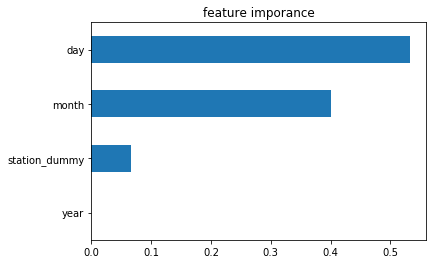

In [8]:
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("feature imporance")
plt.show()

# 3.Predict

In [9]:
station_dummy = pd.Series(np.zeros(2430))
test = pd.concat([test,station_dummy],axis=1)


datetime_test = pd.to_datetime(test.loc[:,"年月日"])
year_test = datetime_test.apply(lambda x:x.year)
month_test = datetime_test.apply(lambda x:x.month)
day_test = datetime_test.apply(lambda x:x.day)

test = pd.concat([test,datetime_test],axis=1)
test = pd.concat([test,year_test],axis=1)
test = pd.concat([test,month_test],axis=1)
test = pd.concat([test,day_test],axis=1)

test.columns = ["id","年月日","列車番号","station_dummy","datetime","year","month","day"]

In [10]:
test_id=test["id"]
test = test[feature_name]
predict = reg.predict(test)
predict = pd.DataFrame(predict)

submission = pd.concat((test_id,predict), axis = 1)

In [11]:
submission.to_csv("sumission.csv", index = False, header = None)

7日前からのデータを追加するアイディアを採用するのがいいかもしれない